<a href="https://colab.research.google.com/github/Vagarh/Master-in-Data-Science-assignments/blob/main/Modelaci%C3%B3n_GARCH_y_RNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 12.6 MB/s eta 0:00:00


# Preparacion del Enviroment

https://www.kaggle.com/code/hassanoukhouya/bitcoin-modeling-and-forecasting-with-the-garch#MODELING

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import scipy
from datetime import date, timedelta
import yfinance as yf
import pickle
from statsmodels.stats.diagnostic import het_arch
from statsmodels.compat import lzip
import statsmodels.api as sm
import pandas as pd
import numpy as np
from arch import arch_model

In [25]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

In [71]:
from scipy import stats
import os
from datetime import datetime, timedelta

In [110]:
# The measures of performances
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [51]:
# Libraries of Autocorrelation and Partial  Autocorrelation for identifier lag of GARCH model
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as sgt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.tsa.stattools import adfuller

In [39]:
# GARCH modeling
from arch import arch_model
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from scipy.stats import probplot, moment

# Parte 1 Modelacion Volatidad GARCH


# Obtencion de los datos del activo financiero

In [3]:

# Definir los símbolos de las acciones
symbols = ['GOOGL', 'OIL', 'NFLX']

# Obtener los datos de las acciones
data = yf.download(symbols, start="2021-01-01", end="2024-3-20")

# Filtrar solo las columnas de interés
data = data['Adj Close']

# Agregar una columna DATE con el índice (que es la fecha)
data['DATE'] = data.index

# Reorganizar las columnas en el orden deseado
columns_order = ['DATE', 'GOOGL', 'OIL', 'NFLX']
data = data[columns_order]
data.set_index("DATE", inplace=True)

# Mostrar el DataFrame
data.head(5)

[*********************100%%**********************]  3 of 3 completed


Ticker,GOOGL,OIL,NFLX
DATE,,,
2021-01-04,86.306503,13.8693,522.859985
2021-01-05,87.002502,14.5201,520.799988
2021-01-06,86.143997,14.6000,500.489990
2021-01-07,88.717003,14.7800,508.890015
2021-01-08,89.891502,15.1306,510.399994


# Analisis Exploratorio de los datos

In [4]:
data.dropna(inplace=True)

In [5]:
data.isna().sum()

Ticker
GOOGL    0
OIL      0
NFLX     0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 641 entries, 2021-01-04 to 2023-07-21
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GOOGL   641 non-null    float64
 1   OIL     641 non-null    float64
 2   NFLX    641 non-null    float64
dtypes: float64(3)
memory usage: 20.0 KB


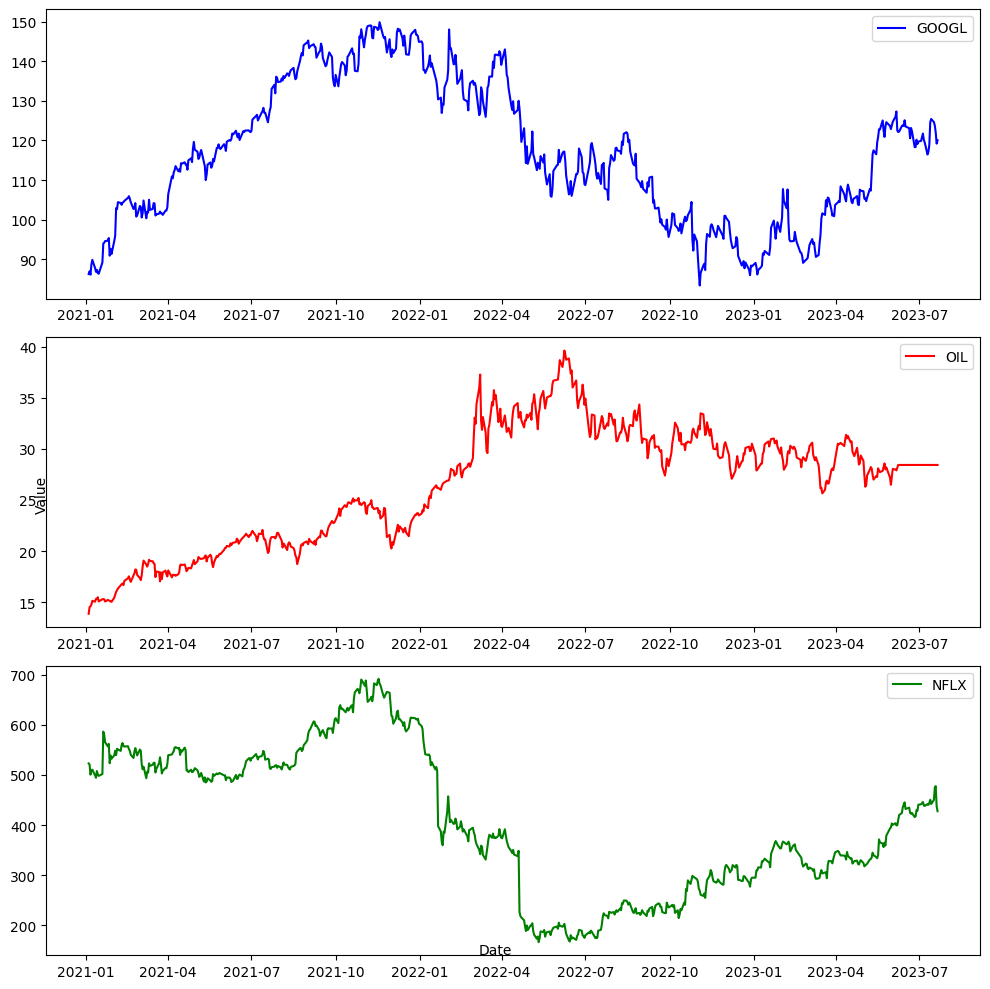

In [7]:
# Create a figure and an array of subplots with 3 rows and 1 column
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# Plot the time series data on each subplot
axs[0].plot(data.index, data['GOOGL'], color='blue', label='GOOGL')
axs[1].plot(data.index, data['OIL'], color='red', label='OIL')
axs[2].plot(data.index, data['NFLX'], color='green', label='NFLX')

# Add legend to each subplot
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Set common x and y labels
fig.text(0.5, 0.04, 'Date', ha='center')
fig.text(0.04, 0.5, 'Value', va='center', rotation='vertical')

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Show the plot
plt.show()

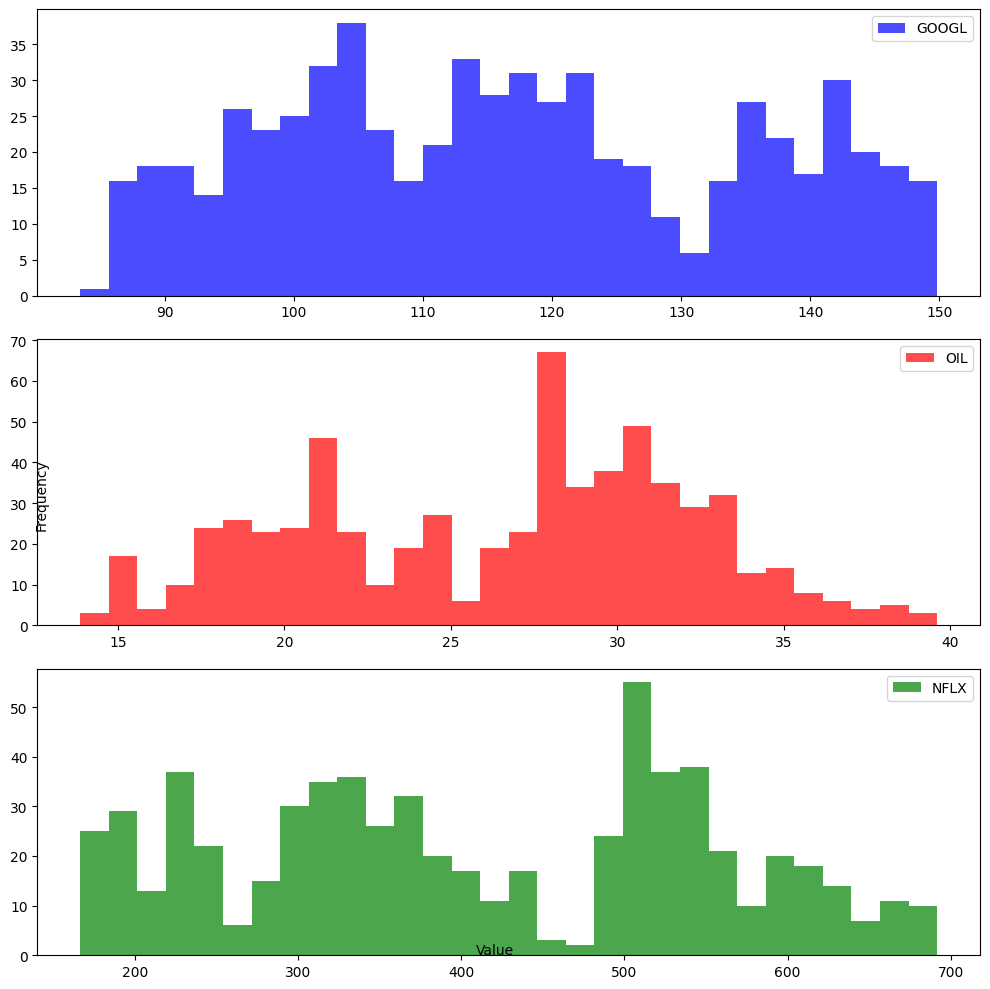

In [8]:
# Create a figure and an array of subplots with 3 rows and 1 column
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# Plot histograms for each column on each subplot
axs[0].hist(data['GOOGL'], color='blue', bins=30, alpha=0.7, label='GOOGL')
axs[1].hist(data['OIL'], color='red', bins=30, alpha=0.7, label='OIL')
axs[2].hist(data['NFLX'], color='green', bins=30, alpha=0.7, label='NFLX')

# Add legend to each subplot
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Set common x and y labels
fig.text(0.5, 0.04, 'Value', ha='center')
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical')

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Show the plot
plt.show()


## Estudio de la Serie de Tiempo

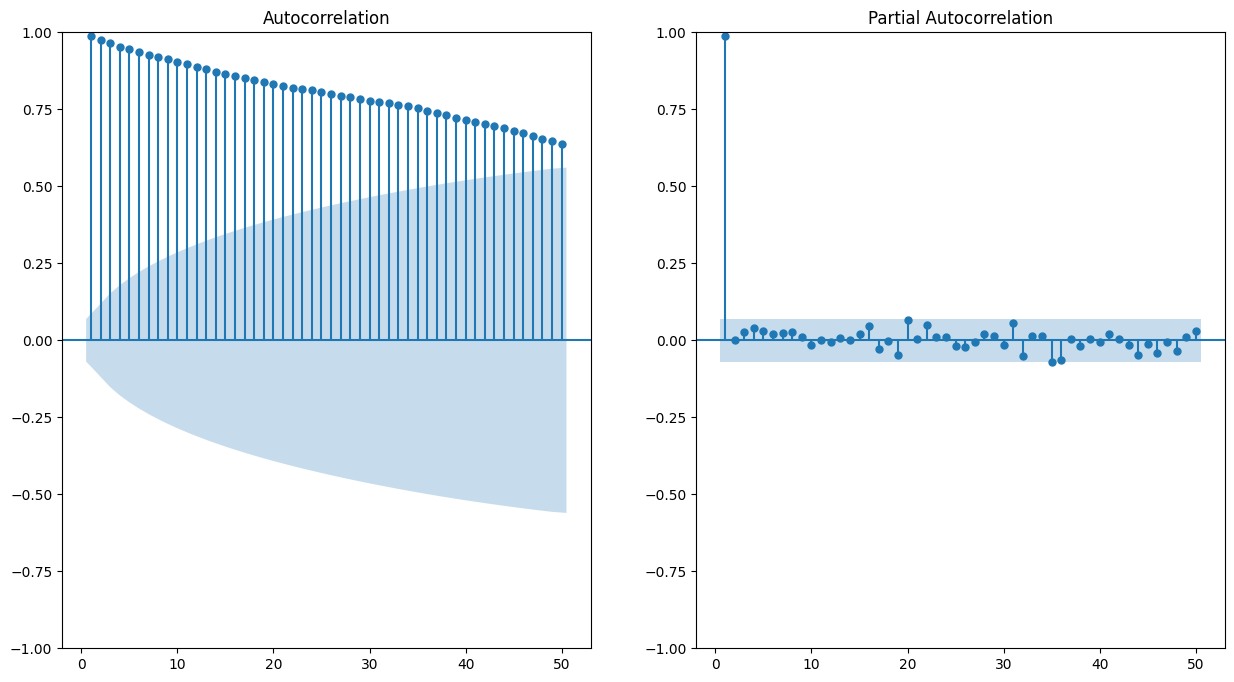

In [38]:
plt.rcParams["figure.figsize"] = 15, 8
fig, axes = plt.subplots(1, 2, sharex=True)
sgt.plot_acf(data.GOOGL, ax=axes[0],zero=False,lags=50);
sgt.plot_pacf(data.GOOGL, ax=axes[1],zero=False,lags=50);

Analysis of ACF and PACF plots

In [40]:
#Perform Dickey-Fuller test:
print ('Results of Augmented Dickey-Fuller Test:')
dftest = adfuller(data.GOOGL, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -2.086557
p-value                          0.249955
#Lags Used                       0.000000
Number of Observations Used    806.000000
Critical Value (1%)             -3.438489
Critical Value (5%)             -2.865133
Critical Value (10%)            -2.568683
dtype: float64


The results of the ADF test are shown above. At the
5
%
 significance level, the null hypothesis (
H
0
) of the existence of a unit root in the series of the close price of Bitcoin is accepted (because the p-value (0.983) is higher than
5
%
). These results indicate that the close price series is not stationary

In [41]:
def test_stationarity(timeseries):
    #determine rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=24).mean()#24 hours on each day
    rolstd = pd.Series(timeseries).rolling(window=24).std()
    #plot rolling statistics
    orig = plt.plot(timeseries,color = 'blue',label='original')
    mean = plt.plot(rolmean,color = 'red',label = 'rolling mean')
    std = plt.plot(rolstd,color = 'black',label = 'rolling std')
    plt.legend(loc = 'best')
    plt.title('Rolling mean and standard deviation of Bitcoin Return')
    plt.show(block = False)
    #perform dickey fuller test
    print('result of dickey fuller test:')
    dftest = adfuller(timeseries,autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4],index = ['Test statistics', 'p-value', '#lags used', 'number of observation used'])
    for key,value in dftest[4].items():
        dfoutput['critical value (%s)'%key] = value
    print(dfoutput)

# Making the serie Stationary

In [42]:
# Calculate price returns as daily percentage change using pct_change()
data['returns'] = 100 * data.GOOGL.pct_change().dropna()

In [43]:
# Calculate log returns based on above formula
data['log_returns'] = np.log(data.GOOGL/data.GOOGL.shift(1))

In [44]:
data.head()

Ticker,GOOGL,returns,log_returns
DATE,,,
2021-01-04,86.306503,NaN,NaN
2021-01-05,87.002502,0.806427,0.008032
2021-01-06,86.143997,-0.986759,-0.009917
2021-01-07,88.717003,2.986866,0.029431
2021-01-08,89.891502,1.323872,0.013152


In [45]:
data.isna().sum()

Ticker
GOOGL          0
returns        1
log_returns    1
dtype: int64

In [47]:
data.dropna(inplace=True)

In [48]:
data['Sq_Returns']=data.returns.mul(data.returns)
data.head()

Ticker,GOOGL,returns,log_returns,Sq_Returns
DATE,,,,
2021-01-05,87.002502,0.806427,0.008032,0.650325
2021-01-06,86.143997,-0.986759,-0.009917,0.973694
2021-01-07,88.717003,2.986866,0.029431,8.921368
2021-01-08,89.891502,1.323872,0.013152,1.752637
2021-01-11,87.814499,-2.310567,-0.023377,5.338720


In [49]:
import seaborn as sns

<ipython-input-54-06c7694bb769>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.returns, norm_hist=True, fit=stats.norm, color='blue',
<ipython-input-54-06c7694bb769>:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.log_returns, norm_hist=True, fit=stats.norm, color='green',


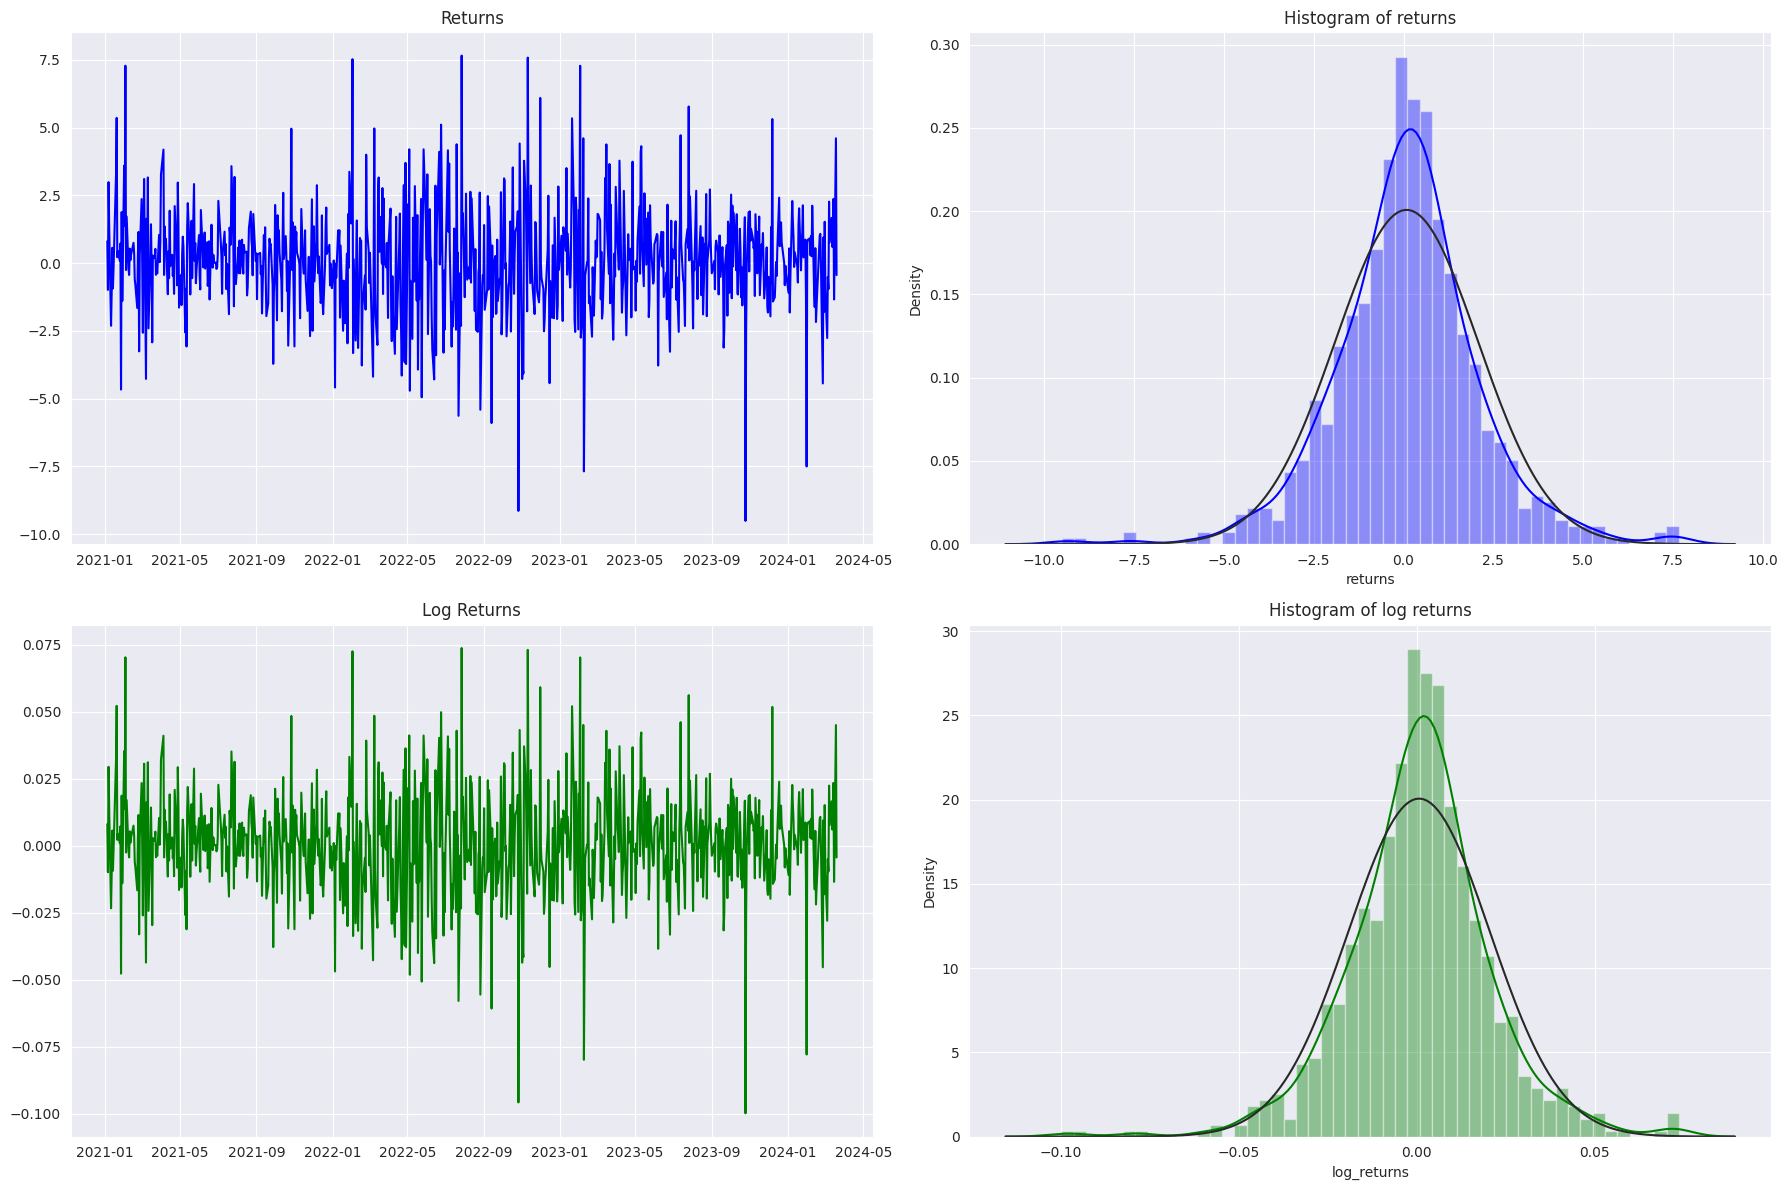

In [54]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12))

    axes[0][0].plot(data.returns, color='blue')
    axes[0][0].set_title('Returns')

    sns.distplot(data.returns, norm_hist=True, fit=stats.norm, color='blue',
                bins=50, ax=axes[0][1])
    axes[0][1].set_title('Histogram of returns')

    axes[1][0].plot(data.log_returns, color='green')
    axes[1][0].set_title('Log Returns')

    sns.distplot(data.log_returns, norm_hist=True, fit=stats.norm, color='green',
                bins=50, ax=axes[1][1])
    axes[1][1].set_title('Histogram of log returns')
    plt.tight_layout()
    plt.savefig(os.path.join( 'returns_logreturns.png'),
                dpi=300, bbox_inches='tight')
    fig.show();

In [55]:
data.returns.describe()

count    806.000000
mean       0.085884
std        1.988381
min       -9.509399
25%       -0.964725
50%        0.095657
75%        1.129121
max        7.655686
Name: returns, dtype: float64

In [56]:
data.log_returns.describe()

count    806.000000
mean       0.000661
std        0.019901
min       -0.099924
25%       -0.009694
50%        0.000956
75%        0.011228
max        0.073768
Name: log_returns, dtype: float64

<ipython-input-58-3d53c73028e3>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(212, facecolor="lightgrey")


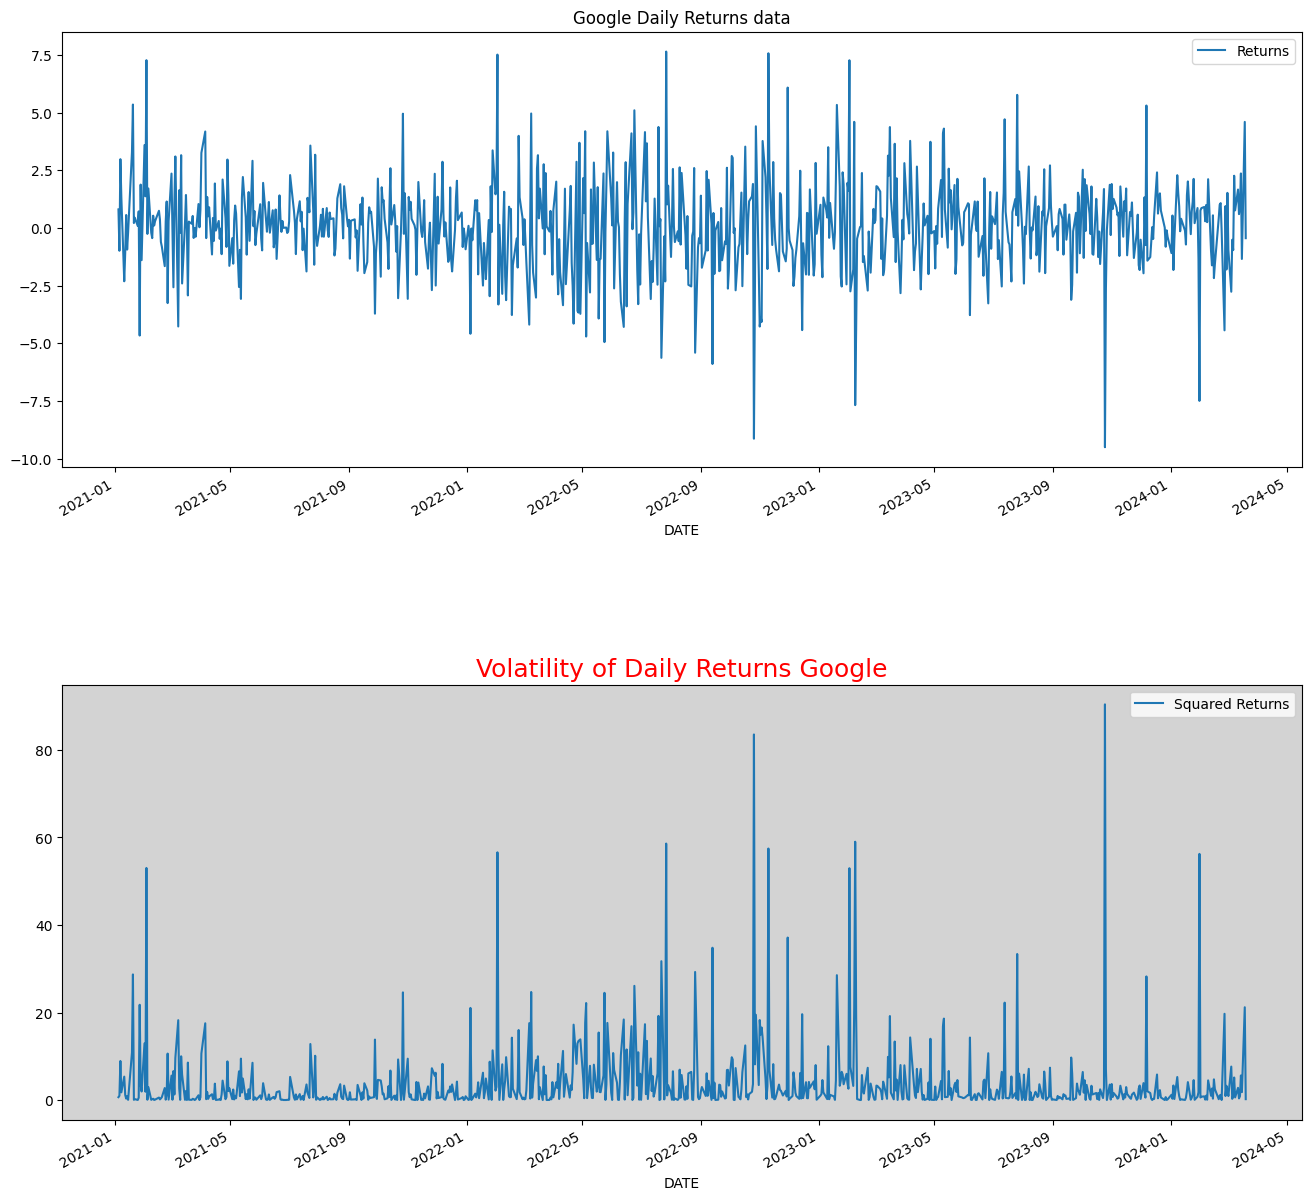

In [58]:
#Plot the Daily Returns
plt.figure(figsize=(16, 16))
plt.subplot(211)
data['returns'].plot(label='Returns')
plt.title('Google Daily Returns data')
plt.legend()
#Plot the Daily Squared Returns
plt.subplot(212)
plt.subplot(212, facecolor="lightgrey")
data['Sq_Returns'].plot(label='Squared Returns')
plt.title('Volatility of Daily Returns Google',color="red",fontsize=18,ha='center')
plt.legend()
# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(hspace=0.5)
plt.show()

# Returns/Log Returns Stationarity Checking¶

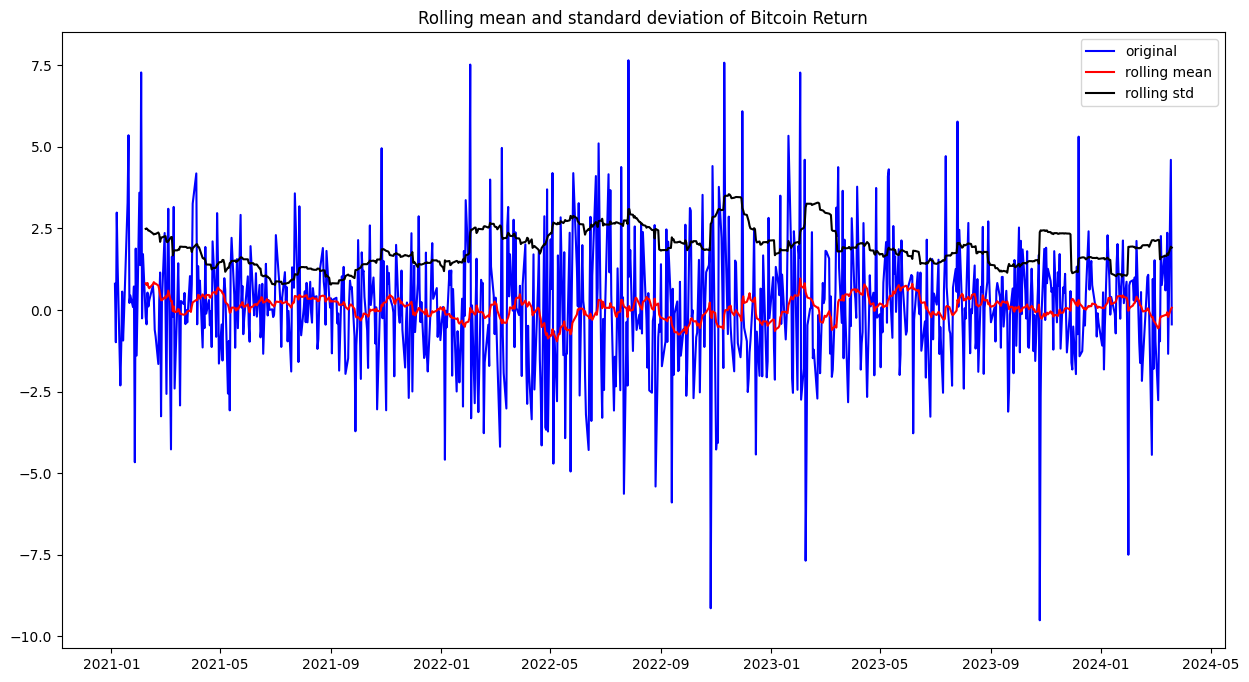

result of dickey fuller test:
Test statistics               -28.469580
p-value                         0.000000
#lags used                      0.000000
number of observation used    805.000000
critical value (1%)            -3.438499
critical value (5%)            -2.865137
critical value (10%)           -2.568685
dtype: float64


In [59]:
#rcParams['figure.figsize'] = 15,10
data['returns'].dropna(inplace=True)
test_stationarity(data['returns'])

In [61]:
# For log returns
adfuller_results = adfuller(data.log_returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -28.426928252838657
p-value: 0.0
Critical Values:
1%: -3.4385
5%: -2.8651
10%: -2.5687


In [63]:
data.shape

(806, 4)

# train-Test Splits¶

In [64]:
data_return= data[["returns"]]

In [65]:
# Pre-determine desired test & validation sizes
test_size = 182


# Convert to indices
split_time_1 = len(data_return) - 182
split_time_2 = len(data_return) - 182

# Get corresponding datetime indices for each set
train_idx = data.index[:split_time_1]
test_idx = data.index[split_time_2:]

In [66]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'TEST \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

TRAINING 	From: 2021-01-05 00:00:00 	to: 2023-06-28 00:00:00 	624 days
TEST 		From: 2023-06-29 00:00:00 	to: 2024-03-19 00:00:00 	182 days


In [67]:
# Split returns into 2 parts (this would be the input for GARCH models)
r_train = data_return.returns[train_idx]
r_test = data_return.returns[test_idx]

In [68]:
r_train.describe()

count    624.000000
mean       0.074113
std        2.054222
min       -9.140508
25%       -1.017744
50%        0.078295
75%        1.154099
max        7.655686
Name: returns, dtype: float64

In [69]:
r_train

DATE
2021-01-05    0.806427
2021-01-06   -0.986759
2021-01-07    2.986866
2021-01-08    1.323872
2021-01-11   -2.310567
                ...   
2023-06-22    2.156780
2023-06-23   -0.657739
2023-06-26   -3.269577
2023-06-27   -0.008446
2023-06-28    1.563423
Name: returns, Length: 624, dtype: float64

In [70]:
r_test

DATE
2023-06-29   -0.898654
2023-06-30    0.503777
2023-07-03    0.167088
2023-07-05    1.542951
2023-07-06   -1.347022
                ...   
2024-03-13    0.931403
2024-03-14    2.367847
2024-03-15   -1.341728
2024-03-18    4.604052
2024-03-19   -0.440137
Name: returns, Length: 182, dtype: float64

In [77]:
#Train and test split
#Splitting the dataset into 90% training set and 10% Test set
print(data_return.shape)
train = data_return.iloc[:-182]
test = data_return.iloc[-182:]
print(train.shape,test.shape)

(806, 1)
(624, 1) (182, 1)


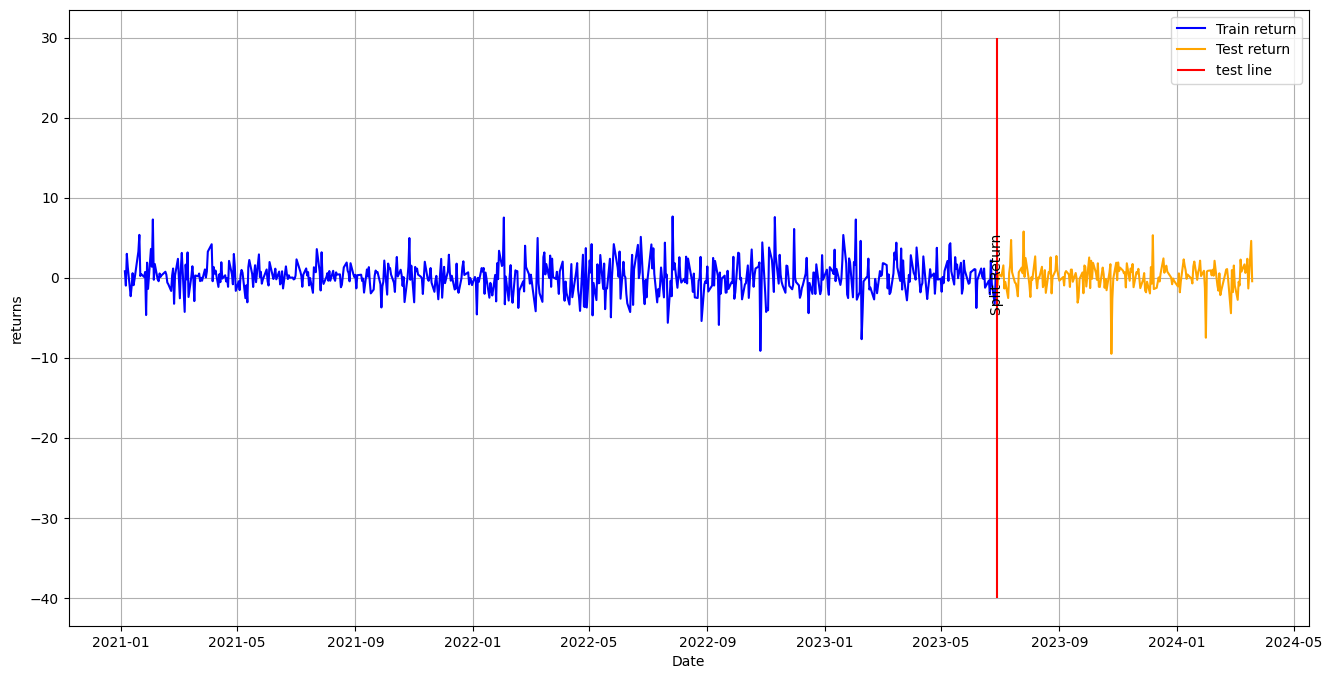

In [80]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('returns')
plt.plot(train['returns'], 'blue', label='Train return')
plt.plot(test['returns'], 'orange', label='Test return')
plt.vlines(x=[datetime(2023, 6, 28)], ymin=-40, ymax=30, color='r', label='test line')
plt.text(datetime(2023, 6, 28), 0.488787, 'Split Return', ha='center', va='center',rotation='vertical')
plt.legend()
plt.show()

# Hurst Exponent function

In [81]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [82]:
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=0.1, y=1.5, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'

    axes[0][1].text(x=.4, y=1.4, s=s, transform=axes[0][1].transAxes)

    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9,hspace=1.5)

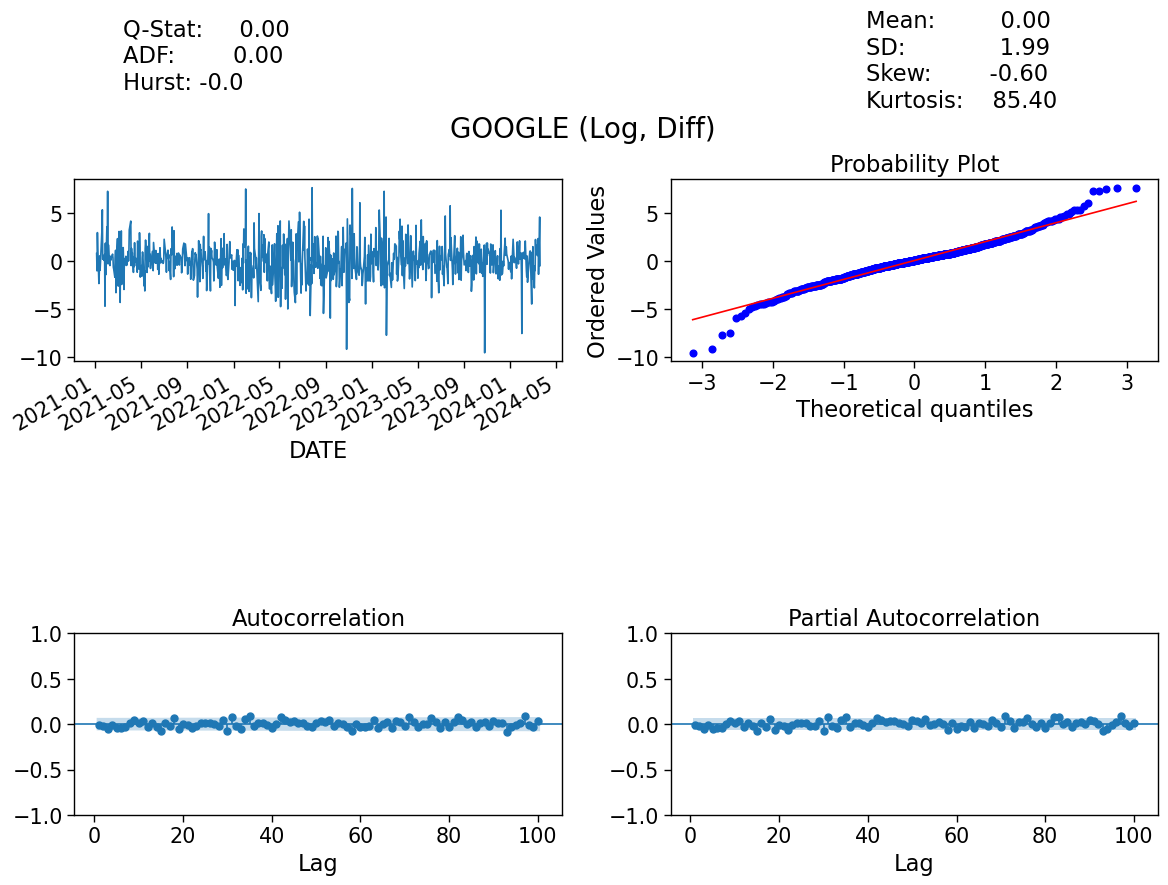

In [129]:
# Plot ACF, PACF and Q-Q plot and get ADF p-value of series
plot_correlogram(data['returns'], lags=100, title='GOOGLE (Log, Diff)')

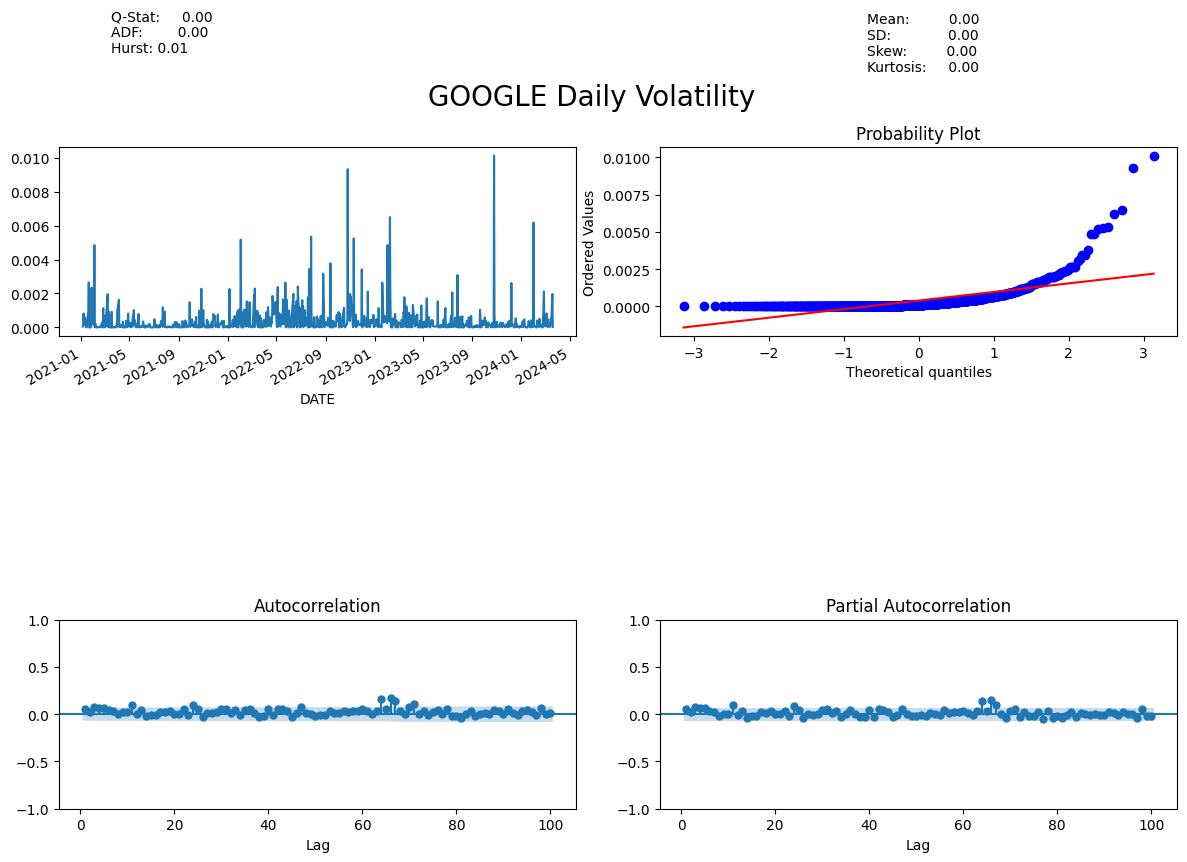

In [85]:
plot_correlogram(data.log_returns.sub(data.log_returns.mean()).pow(2), lags=100, title='GOOGLE Daily Volatility')

In [ ]:
tckr = 'GOOGL'

In [89]:
seed = 2024

# Modeling

## 1 GARCH(1,1) model.

In [90]:
# Set seed for reproducibility
np.random.seed(seed)

model_garch_1 = arch_model(r_train, p=1, q=1)
result_1 = model_garch_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1308.67
Distribution:                  Normal   AIC:                           2625.35
Method:            Maximum Likelihood   BIC:                           2643.09
                                        No. Observations:                  624
Date:                Mon, Apr 22 2024   Df Residuals:                      623
Time:                        00:37:54   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1268  7.301e-02      1.736  8.254e-02 [-1.6

In [91]:
model_garch_2 = arch_model(r_train, vol='GARCH', p=4, q=4)
result_2 = model_garch_2.fit(disp='off')
print()
print(result_2.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1303.67
Distribution:                  Normal   AIC:                           2627.34
Method:            Maximum Likelihood   BIC:                           2671.70
                                        No. Observations:                  624
Date:                Mon, Apr 22 2024   Df Residuals:                      623
Time:                        00:39:17   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1274  7.388e-02      1.724  8.472e-02 [-1.7

In [92]:
model_garch_3 = arch_model(r_train, vol='GARCH', p=7, q=7)
result_3 = model_garch_3.fit(disp='off')
print()
print(result_3.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1300.51
Distribution:                  Normal   AIC:                           2633.03
Method:            Maximum Likelihood   BIC:                           2704.01
                                        No. Observations:                  624
Date:                Mon, Apr 22 2024   Df Residuals:                      623
Time:                        00:39:33   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1438  7.725e-02      1.862  6.264e-02 [-7.5

In [93]:
def transform_volatility_to_scaler(scaler, tf_series):
    '''
    Transform a series to a fitted scaler
    '''
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output

In [94]:
def scale_tf_cond_vol(model_result):
    '''
    Scale & Transform Conditional Volatility
    Estimated by GARCH Models
    '''
    # Obtain estimated conditional volatility from model result
    cond_vol = model_result.conditional_volatility

    # Initiate scaler
    scaler = MinMaxScaler()

    # Fit scaler to model's estimated conditional volatility
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))

    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

In [95]:
# Get volatility scaler & scaled conditional volatility from model result
scaler_garch, scaled_cond_vol = scale_tf_cond_vol(result_1)

In [96]:
# Visualize model's estimated conditional volatility with scaled vol_current calculated above
def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(r_train, color='blue', lw=2,
                label=f'Scaled Interval Daily Return')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();

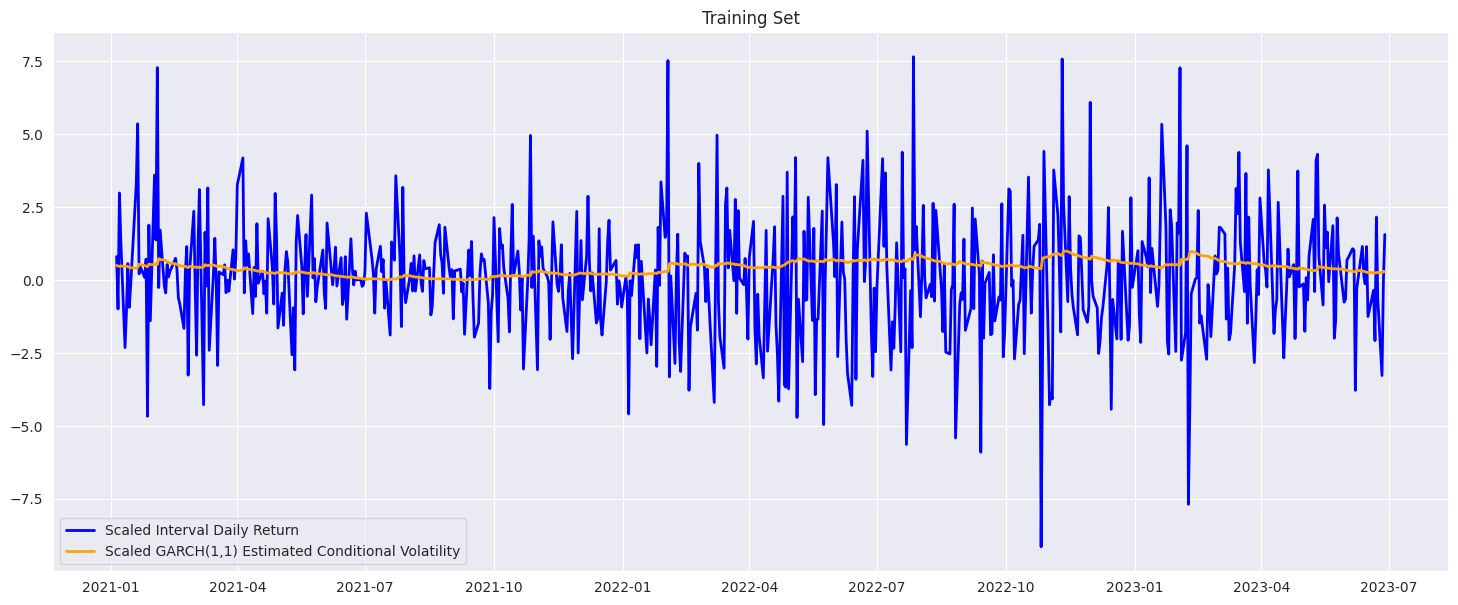

In [97]:
n_future = 182
viz_cond_vol(scaled_cond_vol, 'GARCH(1,1)')


In [100]:
# One step expanding window forecast
# Initializing rolling_forecast
rolling_forecasts = []
idx = data.index

# Iterate over each time step in the validation set
for i in range(len(test_idx)):
    # Get the data at all previous time steps
    idx = test_idx[i]
    train = data.returns[:idx]

    # Train model using all previous time steps' data
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # Make prediction n_future days out
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False).variance.values
    # Get the sqrt of average n_future days variance
    pred = np.sqrt(np.mean(vaR))

    # Append to rolling_forecasts list
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=test_idx)

In [101]:
# Transform predictions using fitted scaler
gm_1_preds_scaled = transform_volatility_to_scaler(scaler_garch, gm_1_preds)

In [102]:
# Plotting model predictions vs. target values
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(r_train, color='gray',  ls=':',
                label=f"Scaled Current Daily Return")

        plt.plot(y_true, color='orange', lw=2,
                label=f"Target Retrun")
        plt.plot(y_pred, color='blue', lw=8.5,
                label=f'Forecasted Return')

        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

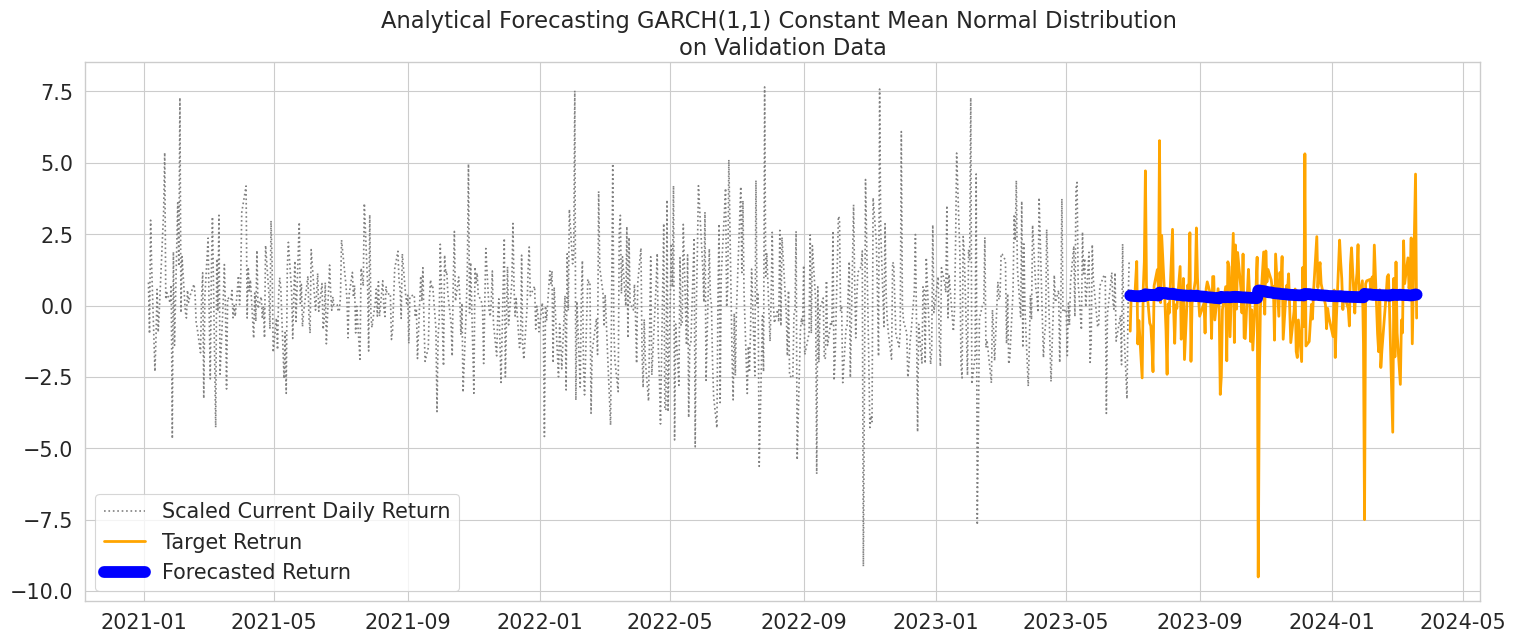

In [103]:
# Plotting predictions vs. target values on validation set
viz_model(r_test, gm_1_preds_scaled,
          'Analytical Forecasting GARCH(1,1) Constant Mean Normal Distribution')

# Metrics

In [104]:
# Define root mean squared percentage error function
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [105]:
# Define root mean squared error function
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [106]:
# Initiate a dataframe for model performance tracking & comparison
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])

In [108]:
# A function that logs model name, rmse and rmpse into perf_df for easy comparison later
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name,
                                       RMSPE(y_true, y_pred),
                                       RMSE(y_true, y_pred)]
    return perf_df

In [111]:
# Append metrics outputs to perf_df dataframe
log_perf(r_test, gm_1_preds_scaled,
         'GARCH(1,1), Constant Mean, Normal Dist')

,Model,Validation RMSPE,Validation RMSE
0,"GARCH(1,1), Constant Mean, Normal Dist",2.388503,1.76226


# Diagnostic checking for GARCH(1,1) Model

<ipython-input-112-0da4c718e7a1>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50)


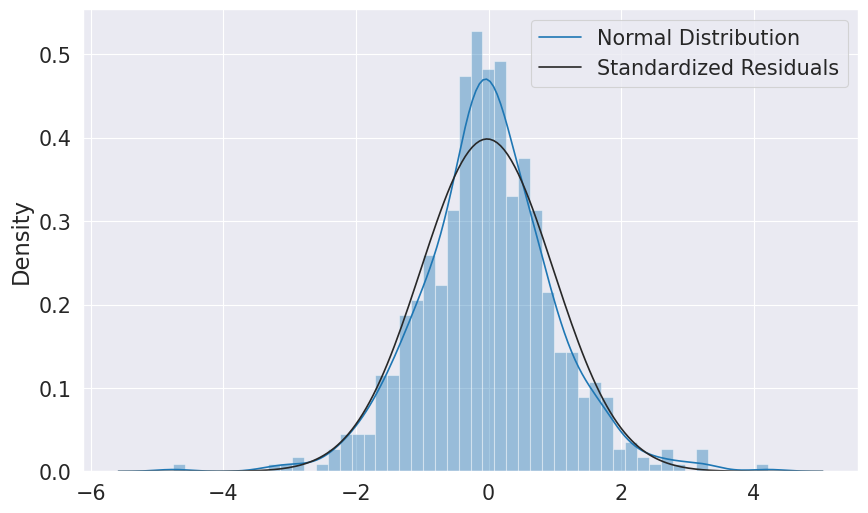

In [112]:
# inspecting the residuals
gm_resid = result_1.resid
gm_std = result_1.conditional_volatility

# Standardizing residuals
gm_std_resid = gm_resid / gm_std

# Visualizing standardized residuals vs. a normal distribution
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10,6))
    sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50)
    plt.legend(('Normal Distribution', 'Standardized Residuals'))
    plt.show();

In [114]:
# Set seed for reproducibility
np.random.seed(seed)

gjr_gm = arch_model(r_train, p=1, q=1, o=1,
                    vol='GARCH', dist='skewt')
result_4 = gjr_gm.fit(disp='off')
print(result_4.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -1287.49
Distribution:      Standardized Skew Student's t   AIC:                           2588.97
Method:                       Maximum Likelihood   BIC:                           2620.02
                                                   No. Observations:                  624
Date:                           Mon, Apr 22 2024   Df Residuals:                      623
Time:                                   00:51:39   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
--------------------------------------------

In [115]:
# Get volatility scaler & scaled conditional volatility from model result
scaler_gjr, scaled_gjr_cond_vol = scale_tf_cond_vol(result_4)

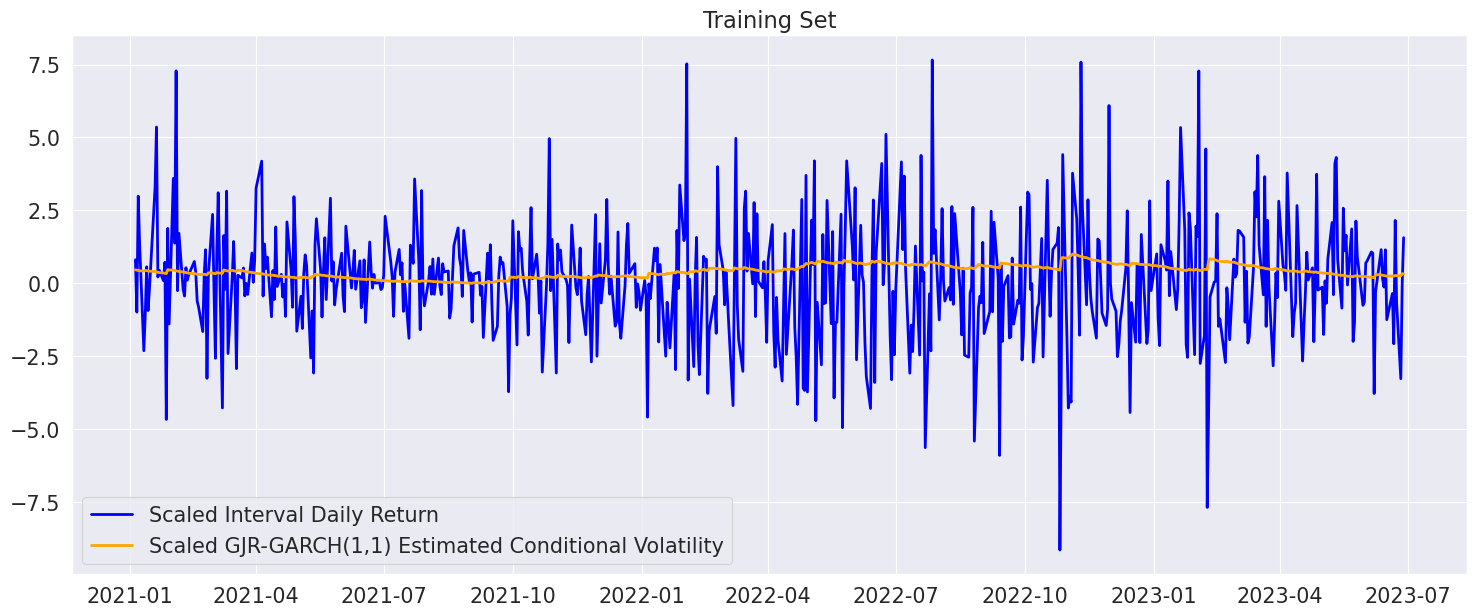

In [116]:
viz_cond_vol(scaled_gjr_cond_vol, 'GJR-GARCH(1,1)')

In [118]:
# Rolling window forecast
# Initializing rolling_forecasts values list
rolling_forecasts = []

# Iterate over each time step in the validation set
for i in range(len(test_idx)):
    # Get the data at all previous time steps
    idx = test_idx[i]
    train = data.returns[:idx].dropna()

    # Train model using all previous time steps' data
    model = arch_model(train, p=1, q=1, o=1,
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # Make prediction n_future days out
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # Append to rolling_forecasts list
    rolling_forecasts.append(pred)

gjr_1_preds = pd.DataFrame(rolling_forecasts, index=test_idx)

In [119]:
# Transform predictions using fitted scaler
gjr_1_preds_scaled = transform_volatility_to_scaler(scaler_gjr, gjr_1_preds)

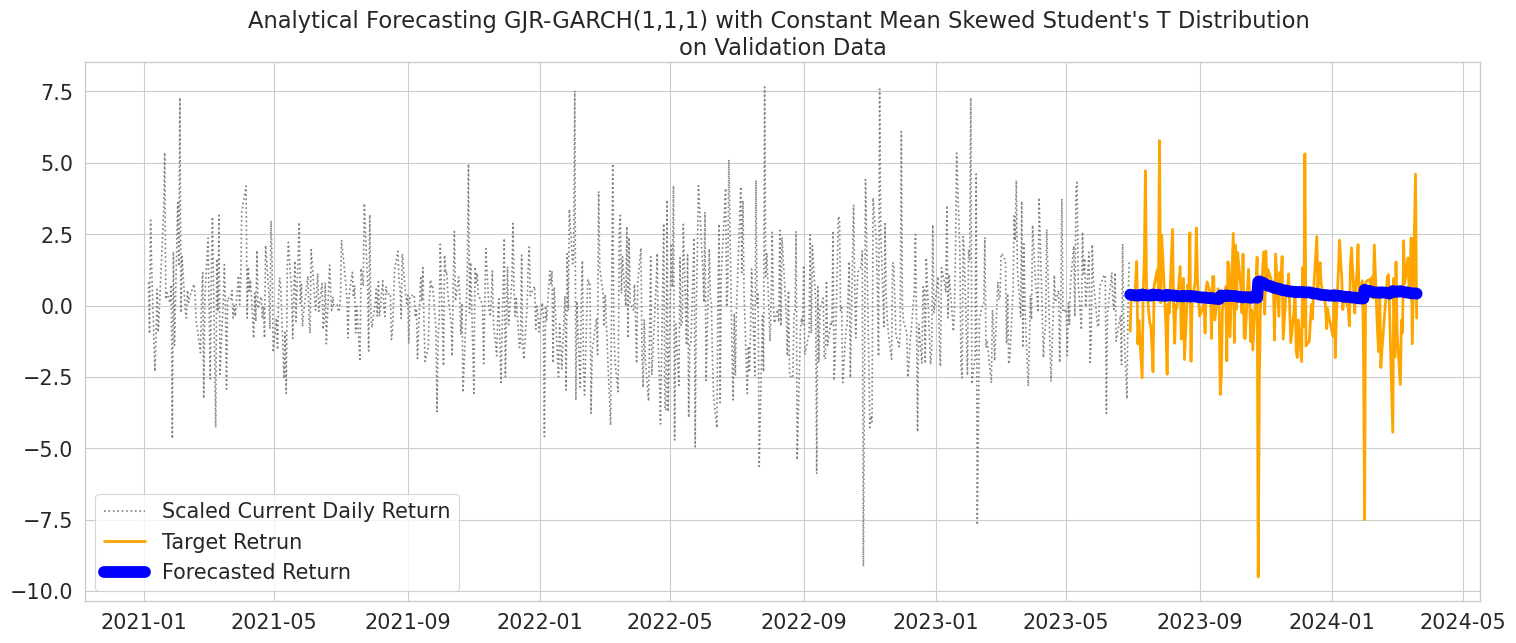

In [120]:
# Plotting predictions vs. target values on validation set
viz_model(r_test, gjr_1_preds_scaled,
          "Analytical Forecasting GJR-GARCH(1,1,1) with Constant Mean Skewed Student's T Distribution")

In [121]:
# Append metrics outputs to perf_df dataframe
log_perf(r_test, gjr_1_preds_scaled,
         "Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist")

,Model,Validation RMSPE,Validation RMSE
0,"GARCH(1,1), Constant Mean, Normal Dist",2.388503,1.762260
1,"Analytical GJR-GARCH(1,1,1), Constant Mean, Sk...",2.443711,1.788258


# Make forecast with GARCH models

In [122]:
rolling_predictions = []
test_size = 182
for i in range(test_size):
  train = data_return[:-(test_size-i)]
  model = arch_model(train['returns'], p=1, q=1)
  model_fit = model.fit(disp='off')
  pred = model_fit.forecast(horizon=1)
  rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [123]:
rolling_predictions = pd.Series(rolling_predictions, index=data_return["returns"].index[-182:])

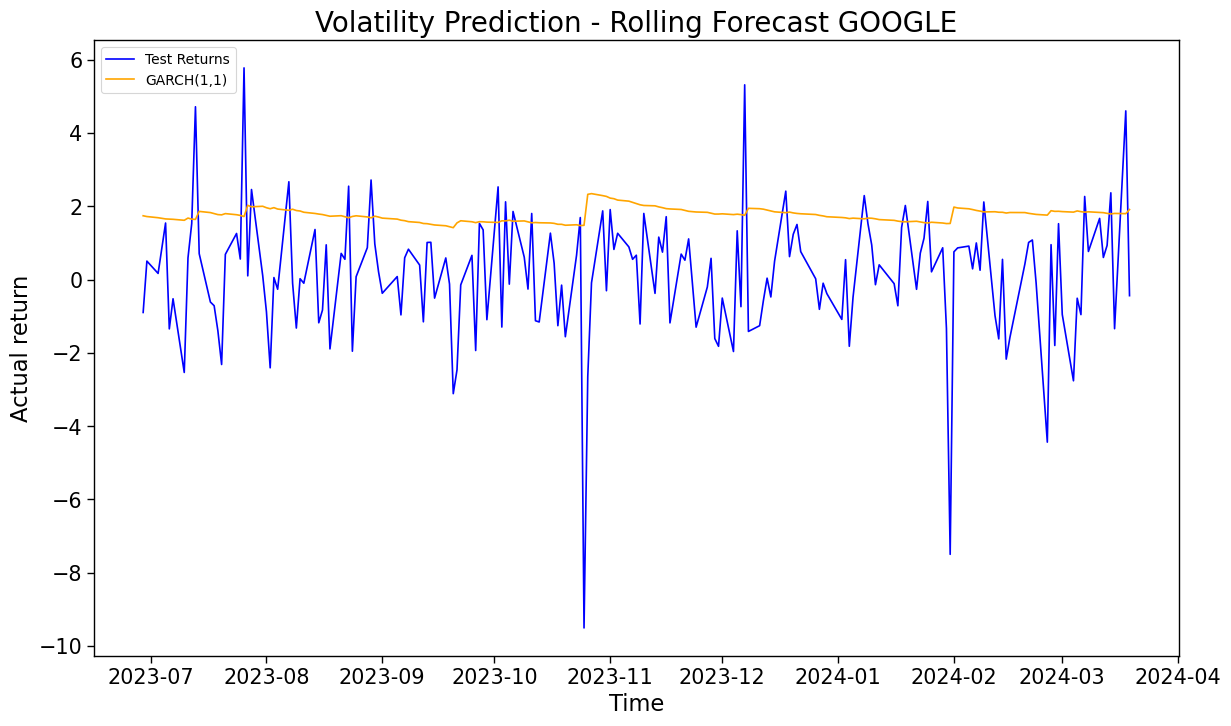

In [125]:
plt.figure(figsize=(14,8))
true, = plt.plot(data_return.returns[-182:],color = 'blue')
preds, = plt.plot(rolling_predictions,color = 'orange')
plt.title('Volatility Prediction - Rolling Forecast GOOGLE', fontsize=20)
plt.legend(['Test Returns', 'GARCH(1,1)'], loc='upper left', fontsize=10)
plt.xlabel('Time')
plt.ylabel('Actual return')
plt.show()

# Forecast Performance Measures

In [126]:
# report performance
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
mse = mean_squared_error(test['returns'], rolling_predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(test['returns'], rolling_predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test['returns'], rolling_predictions))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(rolling_predictions - test['returns'])/np.abs(test['returns']))
print('MAPE: '+str(mape))

MSE: 5.699885646269202
MAE: 1.8841319962472567
RMSE: 2.3874433283890117
MAPE: 4.658065176034974


In [127]:
# Make 7-period ahead forecast
predd = result_1.forecast(horizon=7)
future_datess = [train["returns"].index[-1] + timedelta(days=i) for i in range(1,8)]
predd = pd.Series(np.sqrt(predd.variance.values[-1,:]), index=future_datess)

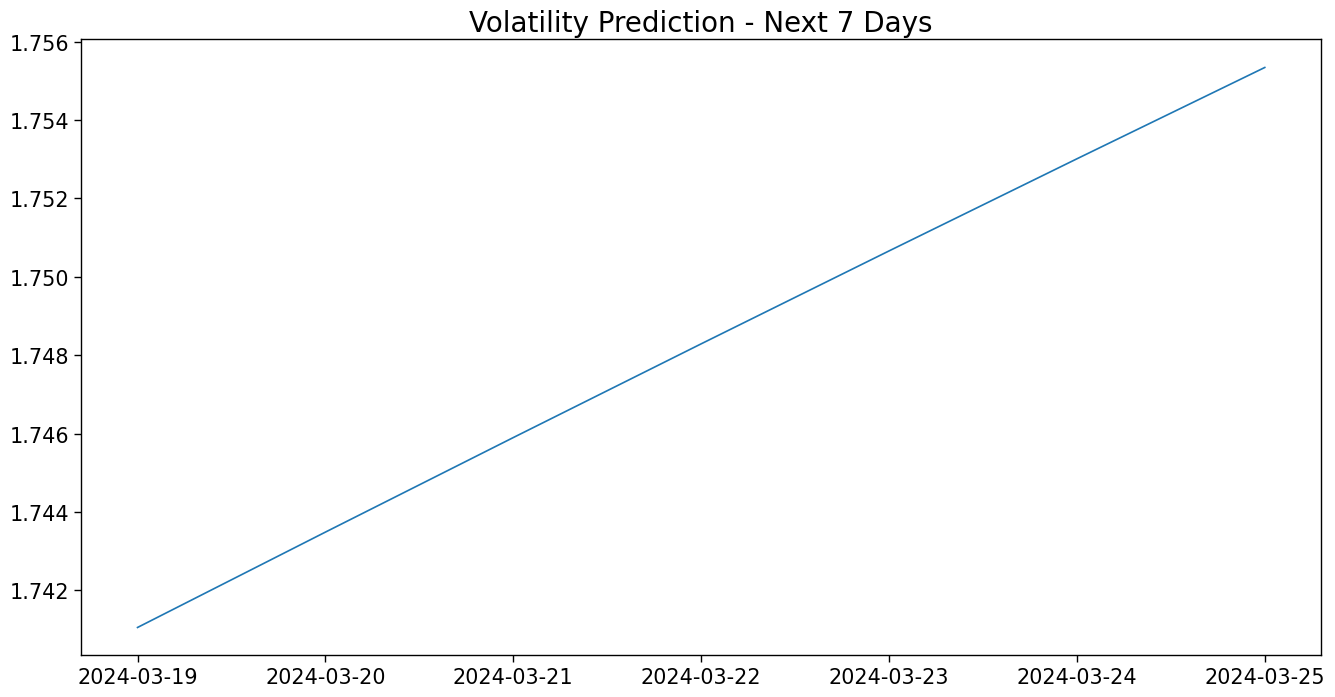

In [128]:
plt.figure(figsize=(16,8))
plt.plot(predd)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)
plt.show()

# Conclusiones Parte 1 Modelacion Volatidad

# Parte 2:Predicción de tasas de cambio mediante redes neuronales

In [22]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dropout, Dense
import tensorflow as tf

In [20]:

# Definir los símbolos de las acciones
symbols = ['GOOGL', 'OIL', 'NFLX']

# Obtener los datos de las acciones
data = yf.download(symbols, start="2021-01-01", end="2024-3-20")

# Filtrar solo las columnas de interés
data = data['Adj Close']

# Agregar una columna DATE con el índice (que es la fecha)
data['DATE'] = data.index

# Reorganizar las columnas en el orden deseado
columns_order = ['DATE', 'GOOGL']
data = data[columns_order]
data.set_index("DATE", inplace=True)

# Mostrar el DataFrame
data.head(5)

[*********************100%%**********************]  3 of 3 completed


Ticker,GOOGL
DATE,
2021-01-04,86.306503
2021-01-05,87.002502
2021-01-06,86.143997
2021-01-07,88.717003
2021-01-08,89.891502


Se continua usando el mismo archivo de datos del activo financiero GOOGLE

In [6]:
data.shape

(807, 1)

In [7]:
rates = np.array(data.GOOGL).reshape(-1, 1)
rates.shape

(807, 1)

In [8]:
# Normalize the interest rates to a common scale to prevent features with large ranges from dominating the model
scaler = MinMaxScaler()  # Create an instance of the MinMaxScaler, which scales and translates data

# Fit the scaler to the rates data and transform it to a normalized scale between 0 and 1
normalized_rates = scaler.fit_transform(rates)

# Print the first 5 normalized rates to verify the transformation
normalized_rates[:5]

array([[0.04104599],
       [0.05097749],
       [0.03872713],
       [0.07544239],
       [0.09220181]])

In [9]:
# Set the number of time steps to consider for each sample in the dataset
TIME_STEPS = 7

# Initialize an empty list to store the formatted rates
formatted_rates = []

# Iterate over the normalized rates, creating sub-sequences of length TIME_STEPS + 1
for i in range(len(normalized_rates) - TIME_STEPS):
  # Append a sub-sequence of TIME_STEPS + 1 consecutive rates to the formatted_rates list
  formatted_rates.append(normalized_rates[i: i + TIME_STEPS + 1])

# Print the first formatted rate to verify the transformation
formatted_rates[0]

array([[0.04104599],
       [0.05097749],
       [0.03872713],
       [0.07544239],
       [0.09220181],
       [0.0625642 ],
       [0.04910813],
       [0.05611448]])

In [10]:
# Resolve any formatting issues by converting the formatted rates to a NumPy array with float32 data type
data = np.array(formatted_rates).astype('float32')

# Split the data into input features (X) and target values (y)
# Get every first 7 numbers as inputs (features)
X = data[:, :-1]

# Get every 8th number as targets (labels)
y = data[:, -1]

# Print the shapes of the input features (X) and target values (y) to verify the split
X.shape, y.shape

((800, 7, 1), (800, 1))

In [11]:
# Split the dataset into training and testing sets
split = 0.8  # Define the proportion of data to use for training (80% in this case)

# Calculate the index to split the data at
boundary = int(data.shape[0]*split)

# Split the input features (X) into training and testing sets
train_x = X[: boundary]  # Training inputs
test_x = X[boundary: ]  # Testing inputs

# Print the shapes of the training and testing input sets to verify the split
train_x.shape, test_x.shape

((640, 7, 1), (160, 7, 1))

In [12]:
# Split the target values (y) into training and testing sets
train_y = y[: boundary]  # Training targets
test_y = y[boundary: ]  # Testing targets

# Print the shapes of the training and testing target sets to verify the split
train_y.shape, test_y.shape

((640, 1), (160, 1))

## Build and train models

### RNN

In [13]:
# Define a Recurrent Neural Network (RNN) model using the Sequential API
rnn_model = Sequential()

# Add a SimpleRNN layer with 256 units, input shape of (TIME_STEPS, 1), and unroll=False
# This layer will process sequences of length TIME_STEPS with 1 feature at each time step
rnn_model.add(SimpleRNN(256, input_shape=(TIME_STEPS, 1), unroll=False))

# Add a Dropout layer with a dropout rate of 0.2 to prevent overfitting
rnn_model.add(Dropout(0.2))

# Add a Dense layer with 1 unit to output a single value
rnn_model.add(Dense(1))

# Print a summary of the RNN model architecture
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 256)               66048     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 66305 (259.00 KB)
Trainable params: 66305 (259.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# Compile the RNN model with a mean squared error (MSE) loss function, Adam optimizer, and evaluation metrics
rnn_model.compile(loss='mse',
                   optimizer='adam',
                   metrics=['mse', 'mae', 'mape'])  # MSE, MAE, and MAPE metrics for evaluation

# Train the RNN model on the training data with a batch size of 1, 50 epochs, and 20% validation split
history_rnn = rnn_model.fit(train_x, train_y,
              batch_size=1,
              epochs=50,
              validation_split=0.2,
              verbose=2)  # Set verbosity to 2 to display one line per epoch

Epoch 1/50
512/512 - 4s - loss: 0.0164 - mse: 0.0164 - mae: 0.0876 - mape: 471395.2500 - val_loss: 0.0020 - val_mse: 0.0020 - val_mae: 0.0342 - val_mape: 11.6614 - 4s/epoch - 8ms/step
Epoch 2/50
512/512 - 2s - loss: 0.0059 - mse: 0.0059 - mae: 0.0607 - mape: 197539.5781 - val_loss: 0.0074 - val_mse: 0.0074 - val_mae: 0.0786 - val_mape: 30.2773 - 2s/epoch - 4ms/step
Epoch 3/50
512/512 - 2s - loss: 0.0059 - mse: 0.0059 - mae: 0.0586 - mape: 397225.3438 - val_loss: 0.0021 - val_mse: 0.0021 - val_mae: 0.0372 - val_mape: 10.6341 - 2s/epoch - 4ms/step
Epoch 4/50
512/512 - 2s - loss: 0.0040 - mse: 0.0040 - mae: 0.0486 - mape: 215040.7500 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0264 - val_mape: 9.8830 - 2s/epoch - 4ms/step
Epoch 5/50
512/512 - 2s - loss: 0.0029 - mse: 0.0029 - mae: 0.0412 - mape: 220209.0469 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0274 - val_mape: 9.2358 - 2s/epoch - 4ms/step
Epoch 6/50
512/512 - 3s - loss: 0.0036 - mse: 0.0036 - mae: 0.0466 - mape: 182214.

### LSTM

In [15]:
# Define a Long Short-Term Memory (LSTM) model using the Sequential API
lstm_model = Sequential()

# Add an LSTM layer with 256 units, input shape of (TIME_STEPS, 1), and unroll=False
# This layer will process sequences of length TIME_STEPS with 1 feature at each time step
lstm_model.add(LSTM(256, input_shape=(TIME_STEPS, 1), unroll=False))

# Add a Dropout layer with a dropout rate of 0.2 to prevent overfitting
lstm_model.add(Dropout(0.2))

# Add a Dense layer with 1 unit to output a single value
lstm_model.add(Dense(1))

# Print a summary of the LSTM model architecture
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 264449 (1.01 MB)
Trainable params: 264449 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# Compile the LSTM model with a mean squared error (MSE) loss function, Adam optimizer, and evaluation metrics
lstm_model.compile(loss='mse',
                   optimizer='adam',
                   metrics=['mse', 'mae', 'mape'])  # MSE, MAE, and MAPE metrics for evaluation

# Train the LSTM model on the training data with a batch size of 1, 50 epochs, and 20% validation split
history_lstm = lstm_model.fit(train_x, train_y,
              batch_size=1,
              epochs=50,
              validation_split=0.2,
              verbose=2)  # Set verbosity to 2 to display one line per epoch

Epoch 1/50
512/512 - 7s - loss: 0.0077 - mse: 0.0077 - mae: 0.0671 - mape: 356255.2500 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0436 - val_mape: 15.9953 - 7s/epoch - 13ms/step
Epoch 2/50
512/512 - 5s - loss: 0.0052 - mse: 0.0052 - mae: 0.0577 - mape: 253369.6719 - val_loss: 0.0031 - val_mse: 0.0031 - val_mae: 0.0469 - val_mape: 16.3332 - 5s/epoch - 9ms/step
Epoch 3/50
512/512 - 4s - loss: 0.0043 - mse: 0.0043 - mae: 0.0519 - mape: 212219.3594 - val_loss: 0.0025 - val_mse: 0.0025 - val_mae: 0.0377 - val_mape: 12.8709 - 4s/epoch - 8ms/step
Epoch 4/50
512/512 - 4s - loss: 0.0042 - mse: 0.0042 - mae: 0.0517 - mape: 174355.6406 - val_loss: 0.0041 - val_mse: 0.0041 - val_mae: 0.0516 - val_mape: 14.8158 - 4s/epoch - 9ms/step
Epoch 5/50
512/512 - 4s - loss: 0.0032 - mse: 0.0032 - mae: 0.0445 - mape: 211890.1719 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0406 - val_mape: 12.4088 - 4s/epoch - 8ms/step
Epoch 6/50
512/512 - 4s - loss: 0.0034 - mse: 0.0034 - mae: 0.0449 - mape: 1987

### GRUs

In [26]:
np.random.seed(42)
tf.random.set_seed(42)

gru_model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

gru_model.compile(loss='mse',
                   optimizer='adam',
                   metrics=['mse', 'mae', 'mape'])

history_gru = gru_model.fit(train_x, train_y, batch_size=1, epochs=50, validation_split=0.2, verbose=2)

Epoch 1/50
512/512 - 7s - loss: 0.0419 - mse: 0.0419 - mae: 0.1315 - mape: 380959.5938 - val_loss: 0.0052 - val_mse: 0.0052 - val_mae: 0.0549 - val_mape: 21.5908 - 7s/epoch - 13ms/step
Epoch 2/50
512/512 - 2s - loss: 0.0055 - mse: 0.0055 - mae: 0.0569 - mape: 358137.8125 - val_loss: 0.0074 - val_mse: 0.0074 - val_mae: 0.0725 - val_mape: 26.7010 - 2s/epoch - 5ms/step
Epoch 3/50
512/512 - 2s - loss: 0.0046 - mse: 0.0046 - mae: 0.0523 - mape: 342738.2500 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0473 - val_mape: 17.3882 - 2s/epoch - 5ms/step
Epoch 4/50
512/512 - 3s - loss: 0.0045 - mse: 0.0045 - mae: 0.0520 - mape: 365165.0625 - val_loss: 0.0059 - val_mse: 0.0059 - val_mae: 0.0585 - val_mape: 18.4845 - 3s/epoch - 6ms/step
Epoch 5/50
512/512 - 2s - loss: 0.0044 - mse: 0.0044 - mae: 0.0504 - mape: 338185.0625 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0473 - val_mape: 18.0920 - 2s/epoch - 5ms/step
Epoch 6/50
512/512 - 3s - loss: 0.0046 - mse: 0.0046 - mae: 0.0529 - mape: 3472

## Features

In [27]:
# predict with RNN model
rnn_predict = rnn_model.predict(test_x)
# view first few predictions, note that data is normalized
rnn_predict[:5]

5/5 [==============================] - 0s 3ms/step


array([[0.7202179 ],
       [0.6965405 ],
       [0.6433657 ],
       [0.6448719 ],
       [0.64348894]], dtype=float32)

In [28]:
rnn_predict = np.reshape(rnn_predict, (rnn_predict.size, ))
# convert back to original form
rnn_predict_y = scaler.inverse_transform([[i] for i in rnn_predict])
rnn_predict_y[:5]

array([[133.90286541],
       [132.24355275],
       [128.51706351],
       [128.62261866],
       [128.52570174]])

In [29]:
# compare to targets
true_y = scaler.inverse_transform(test_y)
true_y[:5]

array([[131.55],
       [128.38],
       [128.45],
       [128.11],
       [131.53]], dtype=float32)

In [30]:
# predict with LSTM model
lstm_predict = lstm_model.predict(test_x)
lstm_predict[:5]

5/5 [==============================] - 0s 6ms/step


array([[0.70861876],
       [0.69518435],
       [0.653887  ],
       [0.6521425 ],
       [0.6466988 ]], dtype=float32)

In [31]:
lstm_predict = np.reshape(lstm_predict, (lstm_predict.size, ))
lstm_predict_y = scaler.inverse_transform([[i] for i in lstm_predict])
lstm_predict_y[:5]

array([[133.0899989 ],
       [132.14851552],
       [129.25439564],
       [129.13214466],
       [128.75064656]])

In [32]:
# predict with GRU model
gru_model_predict = gru_model.predict(test_x)
# view first few predictions, note that data is normalized
gru_model_predict[:5]

5/5 [==============================] - 1s 5ms/step


array([[[0.53623426, 0.53222156, 0.5332022 , 0.53339404, 0.53657526,
         0.5358436 , 0.535573  , 0.5413566 , 0.53696936, 0.53313965],
        [0.5610748 , 0.562769  , 0.558966  , 0.5601675 , 0.5659048 ,
         0.56819576, 0.56356925, 0.5617167 , 0.5637026 , 0.56044334],
        [0.5734168 , 0.5747587 , 0.5711354 , 0.570512  , 0.5791601 ,
         0.5800502 , 0.5745086 , 0.57337976, 0.57389283, 0.5729791 ],
        [0.6683316 , 0.6747599 , 0.6691106 , 0.6662176 , 0.67957634,
         0.68001115, 0.6739781 , 0.6709076 , 0.66875803, 0.66891897],
        [0.67290413, 0.6785902 , 0.6765682 , 0.674711  , 0.6841965 ,
         0.6810545 , 0.680961  , 0.67704487, 0.6755281 , 0.6714088 ],
        [0.71690595, 0.72326344, 0.7202615 , 0.7165456 , 0.73130465,
         0.7266538 , 0.72344285, 0.7217015 , 0.7202788 , 0.71507716],
        [0.72223675, 0.72653776, 0.7251475 , 0.7222304 , 0.73552436,
         0.728585  , 0.7275347 , 0.72774994, 0.7262655 , 0.7185195 ]],

       [[0.5578719 , 0.55

In [33]:
gru_model_predict = np.reshape(gru_model_predict, (gru_model_predict.size, ))
# convert back to original form
gru_model_predict_y = scaler.inverse_transform([[i] for i in rnn_predict])
gru_model_predict_y[:5]

array([[133.90286541],
       [132.24355275],
       [128.51706351],
       [128.62261866],
       [128.52570174]])

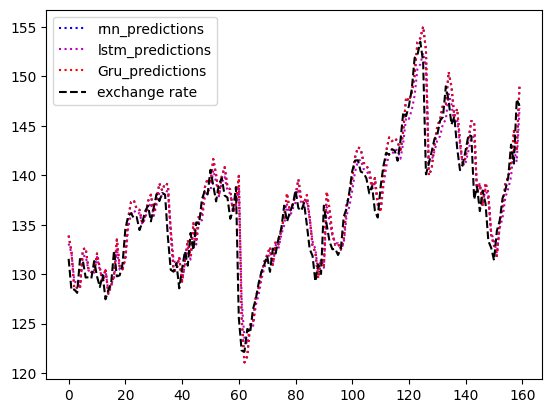

In [34]:
# view predictions
plt.plot(rnn_predict_y, 'b:') ## RNN Predictions GOOGLE
plt.plot(lstm_predict_y, 'm:') ## LSTM Predictions GOOGLE
plt.plot(gru_model_predict_y, 'r:') ## GRU Predictions GOOGLE
plt.plot(true_y, 'k--') ## Real Exchange GOOGLE
plt.legend(['rnn_predictions', 'lstm_predictions',"Gru_predictions", 'exchange rate'])## legend
plt.show()

## Metrics

In [35]:
import pandas as pd

# Define a function to extract metrics from a model's history
def extract_metrics(history):
    metrics = ['loss', 'mse', 'mae', 'mape']
    metrics_values = {}
    for metric in metrics:
        metrics_values[metric] = history.history[metric][-1]
    return metrics_values

# Extract metrics for each model
gru_metrics = extract_metrics(history_gru)
lstm_metrics = extract_metrics(history_lstm)
rnn_metrics = extract_metrics(history_rnn)

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Model': ['GRU', 'LSTM', 'RNN'],
    'Loss': [gru_metrics['loss'], lstm_metrics['loss'], rnn_metrics['loss']],
    'MSE': [gru_metrics['mse'], lstm_metrics['mse'], rnn_metrics['mse']],
    'MAE': [gru_metrics['mae'], lstm_metrics['mae'], rnn_metrics['mae']],
    'MAPE': [gru_metrics['mape'], lstm_metrics['mape'], rnn_metrics['mape']]
})

# Print the DataFrame
print(metrics_df)

  Model      Loss       MSE       MAE           MAPE
0   GRU  0.004148  0.004148  0.049638  349975.750000
1  LSTM  0.001715  0.001715  0.032616   95846.054688
2   RNN  0.001830  0.001830  0.033451  220339.890625


In [36]:
metrics_df

,Model,Loss,MSE,MAE,MAPE
0,GRU,0.004148,0.004148,0.049638,349975.750000
1,LSTM,0.001715,0.001715,0.032616,95846.054688
2,RNN,0.001830,0.001830,0.033451,220339.890625


# Conclusiones Parte 2 Prediccion de tasa de cambio usando Redes Neuronales

Al analizar los resultados, podemos observar que el modelo LSTM tiene la menor pérdida en términos de MSE y MAE, lo que sugiere que produce las predicciones más precisas en comparación con los valores reales. Además, el MAPE del LSTM también es el más bajo entre los tres modelos, lo que indica que tiene el menor error porcentual absoluto medio en relación con los valores reales.

Por otro lado, el modelo GRU parece tener un rendimiento significativamente peor en comparación con los otros dos modelos, ya que muestra valores mucho más altos de todas las métricas de pérdida.

Es importante destacar que, aunque estas métricas proporcionan una indicación general del rendimiento de los modelos, es crucial considerar otros factores, como la complejidad del modelo, el tiempo de entrenamiento y la interpretabilidad, al seleccionar el mejor modelo para un problema específico.

En resumen, basándonos en los resultados proporcionados, el modelo LSTM parece ser el más adecuado para el pronóstico de tasas de cambio del activos financiero debido a su menor pérdida y error porcentual absoluto medio en comparación con los otros modelos evaluados.

https://www.kaggle.com/code/yeemeitsang/rnn-lstm-exchange-rate?scriptVersionId=158505815